<a href="https://colab.research.google.com/github/lustraka/Data_Analysis_Workouts/blob/main/Analyse_Twitter_Data/act_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Report: act_report
* Create a **250-word-minimum written report** called "act_report.pdf" or "act_report.html" that communicates the insights and displays the visualization(s) produced from your wrangled data. This is to be framed as an external document, like a blog post or magazine article, for example.

In [1]:
# Import dependencies
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Store dataframes for further processing
from sqlalchemy import create_engine

# Upload the database from GitHub
url_db = 'https://github.com/lustraka/Data_Analysis_Workouts/blob/main/Analyse_Twitter_Data/weratedogsdata_clean.db?raw=true'
r = requests.get(url_db)
with open('weratedogsdata_clean.db', 'wb') as file:
  file.write(r.content)

# Create SQLAlchemy engine and connect to the database
engine = create_engine('sqlite:///weratedogsdata_clean.db')

# Read dataframes from SQlite database
df_clean = pd.read_sql('SELECT * FROM df_clean', engine)
df_clean.shape

(1657, 14)

In [3]:
breed_fav = pd.DataFrame([df_clean.groupby('breed')['favorite_count'].sum(), df_clean.groupby('breed')['favorite_count'].mean()], index=['favorite_sum', 'favorite_mean']).T

breed_fav['sum_rank'] = breed_fav.favorite_sum.rank(ascending=False)
breed_fav['mean_rank'] = breed_fav.favorite_mean.rank(ascending=False)
breed_fav.head()

,favorite_sum,favorite_mean,sum_rank,mean_rank
breed,,,,
Afghan Hound,45005.0,15001.666667,60.0,5.0
Airedale,55014.0,4584.500000,54.0,80.0
American Staffordshire Terrier,110069.0,7337.933333,32.0,47.0
Appenzeller,12787.0,6393.500000,97.0,57.0
Australian Terrier,19440.0,9720.000000,85.0,29.0


In [4]:
top = 5
breed_fav_top = breed_fav.query(f'sum_rank <= {top} or mean_rank <= {top}')
breed_fav_top

,favorite_sum,favorite_mean,sum_rank,mean_rank
breed,,,,
Afghan Hound,45005.0,15001.666667,60.0,5.0
Bedlington Terrier,131875.0,21979.166667,24.0,1.0
Bouvier Des Flandres,15673.0,15673.000000,92.0,4.0
Chihuahua,680667.0,7562.966667,4.0,43.0
French Bulldog,536168.0,17872.266667,5.0,3.0
Golden Retriever,1713566.0,11055.264516,1.0,19.0
Labrador Retriever,1051672.0,10210.407767,2.0,25.0
Pembroke,923004.0,9819.191489,3.0,27.0
Saluki,84814.0,21203.500000,38.0,2.0


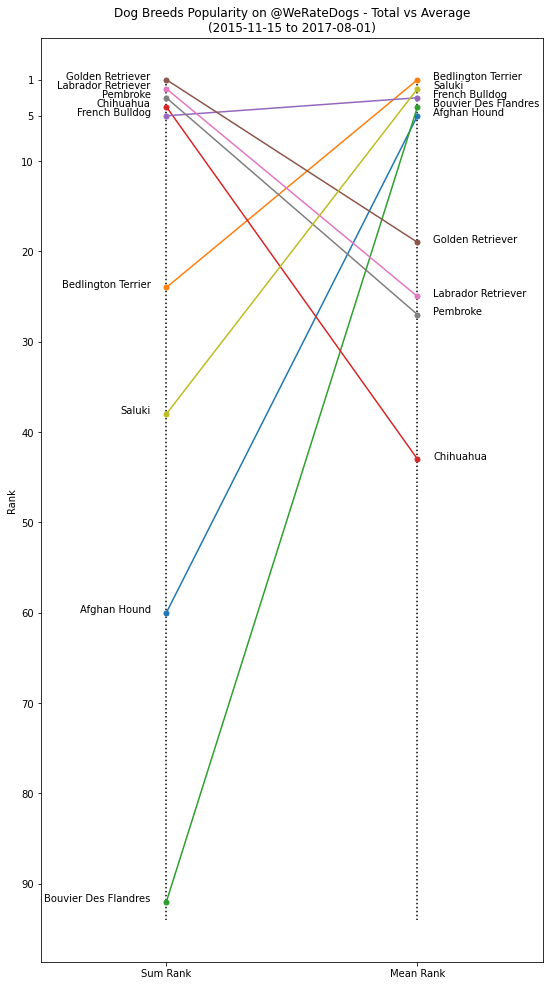

In [24]:
fig, ax = plt.subplots(1, figsize=(9,17))
for b in breed_fav_top.index:
  temp = breed_fav_top[breed_fav_top.index == b]
  plt.plot([2, 6], [temp.sum_rank, temp.mean_rank], marker='o', markersize=5)
  # Sum rank text
  plt.text(1.75, temp.sum_rank, b, ha='right')
  # Mean rank text
  plt.text(6.25, temp.mean_rank, b)
plt.vlines(2, 1, 94, linestyle='dotted')
plt.vlines(6, 1, 94, linestyle='dotted')
# Rendering
plt.xlim([0, 8])
plt.xticks(ticks=[2, 6], labels=['Sum Rank', 'Mean Rank'])
plt.gca().invert_yaxis()
plt.yticks([1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.ylabel('Rank')
plt.title('Dog Breeds Popularity on @WeRateDogs - Total vs Average\n(2015-11-15 to 2017-08-01)')
plt.show()

Cf. [Jan Reisen: The Most Popular Dog Breeds of 2020](https://www.akc.org/expert-advice/dog-breeds/the-most-popular-dog-breeds-of-2020/):

Breed|2020 Rank
---|---
Retrievers (Labrador) | 1 
French Bulldogs | 2 |
German Shepherd Dogs |	3
Retrievers (Golden) |	4
Bulldogs|	5

In [14]:
df_clean.timestamp.min(), df_clean.timestamp.max()

('2015-11-15 22:32:08.000000', '2017-08-01 00:17:27.000000')